# Evaluate Primary Site and Tumor Normal Classifier

In [1]:
import os
import json
import requests
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

# Set so that Tensorflow can pull from the PRP S3/CEPH storage cluster
os.environ["S3_ENDPOINT"] = "s3.nautilus.optiputer.net"

# Switch to a scratch data directory so all paths are local
os.makedirs(os.path.expanduser("~/data/pancan-gtex"), exist_ok=True)
os.chdir(os.path.expanduser("~/data/pancan-gtex"))

# Load Trained Model and Test Data

In [2]:
# Load params and trained model from S3
r = requests.get("https://s3.nautilus.optiputer.net/stuartlab/{}/pancan-gtex/models/params.json".format(
    os.environ["USER"]))
params = r.json()

r = requests.get("https://s3.nautilus.optiputer.net/stuartlab/{}/pancan-gtex/models/model.h5".format(
    os.environ["USER"]))

import tempfile
temp_path = "/tmp/{}.h5".format(next(tempfile._get_candidate_names()))
open(temp_path, "wb").write(r.content)

model = tf.keras.models.load_model(temp_path)
os.remove(temp_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 8160)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 8160)              32640     
_________________________________________________________________
dense_55 (Dense)             (None, 64)                522304    
_________________________________________________________________
dropout_42 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 34)                2210      
Total para

In [3]:
# Setup S3 connection to download and upload data
import boto3

bucket_name = "stuartlab"
session = boto3.session.Session(profile_name=os.getenv("AWS_PROFILE"))
bucket = session.resource("s3", endpoint_url=os.getenv("AWS_S3_ENDPOINT")).Bucket(bucket_name)
print("S3 Profile: {} Endpoint: {} Bucket: {}".format(
    os.getenv("AWS_PROFILE"), os.getenv("AWS_S3_ENDPOINT"), bucket_name))
print("Dataset files:", [obj.key for obj in bucket.objects.filter(Prefix="pancan-gtex")])

S3 Profile: prp Endpoint: https://s3.nautilus.optiputer.net Bucket: stuartlab
Dataset files: ['pancan-gtex', 'pancan-gtex/ensemble-to-hugo.tsv', 'pancan-gtex/pancan-gtex.h5']


In [4]:
if not os.path.exists("pancan-gtex.h5"):
    print("Downloading dataset...")
    bucket.download_file("pancan-gtex/pancan-gtex.h5", "pancan-gtex.h5")
    
print("Loading dataset...")
X = pd.read_hdf("pancan-gtex.h5", "samples")
Y = pd.read_hdf("pancan-gtex.h5", "labels")
print("Loaded {} samples with {} features and {} labels".format(X.shape[0], X.shape[1], Y.shape[1]))

Loading dataset...
Loaded 17277 samples with 8160 features and 40 labels


In [5]:
# Should be 28414.398 - used to verify the total TPM from the hugo version and the transcript version match
X.loc["TCGA-ZT-A8OM-01"].sum()

28414.398

In [6]:
# Convert tumor normal and primary site to numeric values so we can plot confusion and errors againsts them
from sklearn.preprocessing import LabelEncoder

primary_site_encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(primary_site_encoder.fit_transform(Y["_primary_site"]), index=Y.index)

tumor_normal_encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(tumor_normal_encoder.fit_transform(Y["tumor_normal"]), index=Y.index)

In [7]:
Y.loc[params["test_ids"]]._primary_site.value_counts()

Brain                   185
Lung                    141
Breast                  139
Kidney                  104
Skin                    102
Esophagus                85
Prostate                 65
Colon                    64
Stomach                  62
Blood Vessel             60
Thyroid Gland            57
Head and Neck region     57
Liver                    53
Ovary                    52
Adipose Tissue           51
Bladder                  43
Muscle                   40
Heart                    38
Pancreas                 35
Blood                    34
Testis                   32
Cervix                   31
Nerve                    28
Thyroid                  28
Soft tissue,Bone         27
Endometrium              20
Paraganglia              18
White blood cell         18
Adrenal Gland            13
Uterus                   13
Thymus                   12
Pituitary                11
Rectum                   10
Name: _primary_site, dtype: int64

In [8]:
# Predict all test samples
X_test = X.loc[params["test_ids"]]
Y_test = Y.loc[params["test_ids"]]
predictions = model.predict(X_test)

## Evaluate

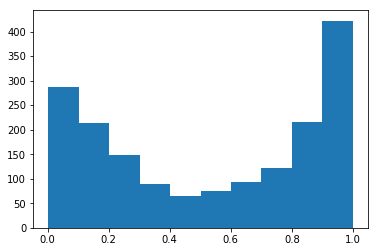

Tumor/Normal Confusion Matrix
[[727  71]
 [ 73 857]]


In [9]:
# Plot the distribution of tumor/normal values and confusion matrix
plt.hist(predictions[:,0])
plt.show()

from sklearn.metrics import confusion_matrix
print("Tumor/Normal Confusion Matrix")
print(confusion_matrix(Y_test["tumor_normal_value"], np.round(predictions[:,0])))

In [10]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix optionally normalized by class size
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

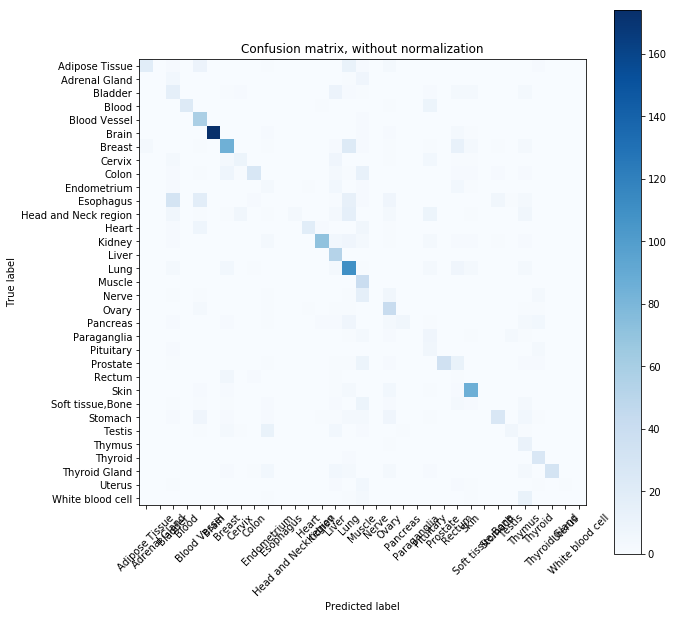

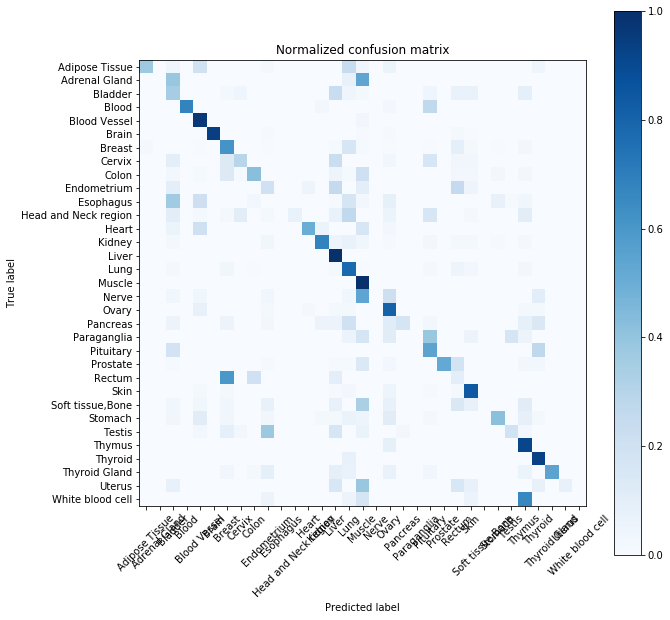

In [11]:
# Plot confusion matrix for primary site
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    Y_test["primary_site_value"], np.array([np.argmax(p[1:-1]) for p in predictions]))

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix, classes=params["primary_site"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()